In [55]:
import numpy as np
import cv2
from scipy import stats
from filterpy.kalman import KalmanFilter
from scipy.spatial.distance import cdist
from ultralytics import YOLO
from scipy.interpolate import splprep, splev
from scipy.integrate import quad

# 初始化YOLO模型
yolo = YOLO("runs/train/exp-seg-EIOU/weights/best.pt", task="detect")

def extract_feature_points(mask, interval=20, min_width=10):
    h, w = mask.shape
    points = []
    for y in range(0, h, interval):
        row = mask[y, :]
        left = np.argmax(row)
        right = w - np.argmax(row[::-1]) - 1
        if right - left > min_width:  # 只在检测到足够宽度的特征时添加点
            x = (left + right) // 2
            points.append((x, y))
    return np.array(points)

def fit_line(points):
    if len(points) < 2:
        return None, None
    x = points[:, 0]
    y = points[:, 1]
    slope, intercept, _, _, _ = stats.linregress(x, y)
    return slope, intercept

def select_main_navigation_line(lines):
    if not lines:
        return None
    center_x, center_y = 320, 640
    distances = []
    for slope, intercept in lines:
        y = slope * center_x + intercept
        distance = abs(y - center_y)
        distances.append(distance)
    return lines[np.argmin(distances)]

def smooth_parameters(slope, intercept):
    kf = KalmanFilter(dim_x=2, dim_z=2)
    kf.x = np.array([slope, intercept])
    kf.F = np.eye(2)
    kf.H = np.eye(2)
    kf.P *= 1000.
    kf.R = np.eye(2) * 0.1
    kf.Q = np.eye(2) * 0.001

    for _ in range(10):
        kf.predict()
        kf.update(np.array([slope, intercept]))

    return kf.x[0], kf.x[1]

def fit_curve_and_get_length(points):
    # 确保点是按y坐标排序的
    points = points[points[:, 1].argsort()]
    
    # 使用样条插值拟合曲线
    tck, _ = splprep([points[:, 0], points[:, 1]], s=0, k=3)
    
    # 创建更密集的点集来绘制平滑曲线
    t = np.linspace(0, 1, 1000)
    smooth_points = np.array(splev(t, tck)).T
    
    # 计算曲线长度
    def curve_length_integrand(t):
        dx_dt, dy_dt = splev(t, tck, der=1)
        return np.sqrt(dx_dt**2 + dy_dt**2)
    
    length, _ = quad(curve_length_integrand, 0, 1)
    
    return smooth_points, length

def draw_curve(image, points, mask, color=(0, 255, 255), thickness=2):
    for i in range(len(points) - 1):
        pt1 = tuple(points[i].astype(int))
        pt2 = tuple(points[i+1].astype(int))
        
        # 只有当两个点都在掩码内时才绘制线段
        if mask[pt1[1], pt1[0]] > 0 and mask[pt2[1], pt2[0]] > 0:
            cv2.line(image, pt1, pt2, color, thickness)

# 主程序
# source = cv2.imread('datasets/mogu_labels_2/images/train/1_20240529_135409.jpg')
source = cv2.imread("Image_1724300959566_edit_478820422488393.jpg")
source = cv2.resize(source, (640, 640))

result = yolo(source, save=True)

if result[0].masks is not None and len(result[0].masks) > 0:
    masks_data = result[0].masks.data
    all_lines = []
    
    for mask in masks_data:
        mask = (mask.cpu().numpy() * 255).astype(np.uint8)
        
        feature_points = extract_feature_points(mask)
        if len(feature_points) > 1:
            smooth_points, curve_length = fit_curve_and_get_length(feature_points)
            draw_curve(source, smooth_points, mask)
            
            print(f"Curve length: {curve_length:.2f} pixels")
            
            slope, intercept = fit_line(feature_points)
            if slope is not None and intercept is not None:
                all_lines.append((slope, intercept))
            
            # 只在掩码区域内绘制特征点
            for point in feature_points:
                if mask[point[1], point[0]] > 0:  # 检查点是否在掩码内
                    cv2.circle(source, tuple(point), 2, (0, 255, 0), -1)
    
    # 选择主导航线
    main_line = select_main_navigation_line(all_lines)
    
    if main_line is not None:
        # 应用卡尔曼滤波
        smoothed_line = smooth_parameters(main_line[0], main_line[1])
        
        # 绘制平滑后的主导航线
        y1 = 0
        x1 = int((y1 - smoothed_line[1]) / smoothed_line[0])
        y2 = 640
        x2 = int((y2 - smoothed_line[1]) / smoothed_line[0])
        # cv2.line(source, (x1, y1), (x2, y2), (0, 0, 255), 2)
        
        # 计算航向偏差和横向偏差
        center_x = 320
        center_y = 640
        angle = np.arctan(smoothed_line[0]) * 180 / np.pi
        heading_error = angle
        lateral_error = abs(center_y - (smoothed_line[0] * center_x + smoothed_line[1]))
        
        print(f"Heading Error: {heading_error:.2f} degrees")
        print(f"Lateral Error: {lateral_error:.2f} pixels")
    
    # 保存结果图像
    cv2.imwrite('result_with_navigation_and_curves.jpg', source)
    print("Saved result image with navigation line and curves")
else:
    print("No masks found in the result")


0: 640x640 7 Stage1s, 41.0ms
Speed: 5.0ms preprocess, 41.0ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict138
Curve length: 839.19 pixels
Curve length: 1117.64 pixels
Curve length: 966.55 pixels
Curve length: 949.52 pixels
Curve length: 1136.80 pixels
Curve length: 671.94 pixels
Curve length: 688.52 pixels
Heading Error: 53.30 degrees
Lateral Error: 281.16 pixels
Saved result image with navigation line and curves


C:\Users\Administrator\AppData\Local\Temp\ipykernel_17304\2105509974.py:75: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  length, _ = quad(curve_length_integrand, 0, 1)


In [56]:
result[0]

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: ultralytics.engine.results.Masks object
names: {0: 'Stage1', 1: 'Stage2', 2: 'Stage3', 3: 'Stage4'}
obb: None
orig_img: array([[[106, 151, 189],
        [119, 166, 204],
        [122, 169, 207],
        ...,
        [122, 167, 205],
        [121, 166, 203],
        [124, 169, 206]],

       [[130, 175, 213],
        [143, 190, 228],
        [140, 189, 227],
        ...,
        [108, 153, 191],
        [106, 151, 189],
        [106, 151, 189]],

       [[117, 164, 202],
        [129, 176, 214],
        [127, 177, 214],
        ...,
        [118, 163, 201],
        [118, 163, 201],
        [117, 162, 200]],

       ...,

       [[116, 157, 189],
        [114, 158, 189],
        [119, 161, 194],
        ...,
        [ 83, 123, 151],
        [ 84, 124, 152],
        [ 85, 126, 153]],

       [[119, 159, 188],
        [114, 155, 187],
        [116, 156, 188],
  

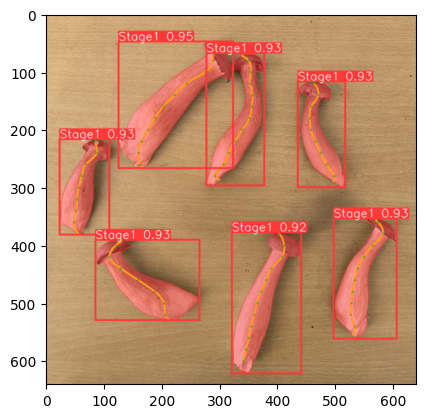

In [57]:
# 检测结果可视化
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(result[0].plot()[:,:,::-1])

In [58]:
result[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
conf: tensor([0.9454, 0.9340, 0.9332, 0.9294, 0.9285, 0.9270, 0.9231], device='cuda:0')
data: tensor([[125.9218,  47.8385, 323.1597, 266.0342,   0.9454,   0.0000],
        [497.6171, 353.3890, 606.3514, 561.2631,   0.9340,   0.0000],
        [ 85.2044, 390.5292, 265.7992, 529.2181,   0.9332,   0.0000],
        [435.2660, 116.3026, 517.5707, 299.7300,   0.9294,   0.0000],
        [ 23.8956, 216.8882, 109.2310, 381.8969,   0.9285,   0.0000],
        [277.0750,  67.8314, 377.7175, 296.9901,   0.9270,   0.0000],
        [321.8290, 377.4758, 441.9645, 621.0958,   0.9231,   0.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (640, 640)
shape: torch.Size([7, 6])
xywh: tensor([[224.5408, 156.9364, 197.2379, 218.1957],
        [551.9843, 457.3260, 108.7343, 207.8741],
        [175.5018, 459.8737, 180.5948, 138.6890],
        [476.4184, 208.0163,  82.3047, 183.4274],
 

In [59]:
result[0].masks.xy

[array([[        278,          48],
        [        277,          49],
        [        276,          49],
        [        275,          50],
        [        274,          50],
        [        273,          51],
        [        273,          52],
        [        272,          53],
        [        272,          59],
        [        273,          60],
        [        273,          61],
        [        275,          63],
        [        276,          63],
        [        277,          64],
        [        278,          64],
        [        279,          65],
        [        279,          67],
        [        278,          68],
        [        278,          69],
        [        275,          72],
        [        274,          72],
        [        267,          79],
        [        266,          79],
        [        265,          80],
        [        264,          80],
        [        261,          83],
        [        260,          83],
        [        259,       